**Классификация негативных комментариев**

**Подготовка данных**

*Импорт библиотек*

In [ ]:
from train import dummy_mod
from train import logreg_mod
from train import rf_model
from train import mnb_model
from train import svm_model
from train import knn_model
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%pip install seaborn
import nltk
import re
from tqdm import tqdm
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
!pip install catboost
from catboost import CatBoostClassifier
from nltk.corpus import words
from pymystem3 import Mystem
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix
!pip install torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
!pip install sentencepiece sacremoses
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
!pip install scikit-learn-intelex --progress-bar off >> /tmp/pip_sklearnex.log
from sklearnex import patch_sklearn
from sklearn.svm import SVC
!pip install optuna
import optuna
from sklearn.preprocessing import LabelEncoder


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



# Загрузка и знакомство с данными

In [ ]:
df = pd.read_excel('/content/М.Тех_ТЗ_Датасет_DS_NLP.xlsx')
df_backup = pd.read_excel('/content/М.Тех_ТЗ_Датасет_DS_NLP.xlsx')
display(df)
df.info()

,Unnamed: 0,id,text,class
0,0,45,негатив к вам и горячей линии которые нафиг н...,Консультация КЦ
1,1,97,перестаньте впаривать клиентам дополнительные ...,Компетентность продавцов/ консультантов
2,2,105,продавец предложил наклеить защитную плёнку з...,Компетентность продавцов/ консультантов
3,3,127,продавец режил продать нам товар почему то по ...,Компетентность продавцов/ консультантов
4,4,130,навязанные услуги ( без моего согласия) на сум...,Компетентность продавцов/ консультантов
...,...,...,...,...
2832,2832,17570,почему отключили электронную очередь через пол...,Электронная очередь
2833,2833,17579,очередь на кассе. продавцы не торопятся с зака...,Время ожидания у кассы
2834,2834,17586,"профессионализма менеджеру бы, да и внимания к...",Обслуживание продавцами/ консультантами
2835,2835,17591,сотрудник на выдаче заказа потребовал документ...,Электронная очередь


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2837 entries, 0 to 2836
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2837 non-null   int64 
 1   id          2837 non-null   int64 
 2   text        2837 non-null   object
 3   class       2837 non-null   object
dtypes: int64(2), object(2)
memory usage: 88.8+ KB


In [ ]:
df.shape

(2837, 4)

In [ ]:
df.head()

,Unnamed: 0,id,text,class
0,0,45,негатив к вам и горячей линии которые нафиг н...,Консультация КЦ
1,1,97,перестаньте впаривать клиентам дополнительные ...,Компетентность продавцов/ консультантов
2,2,105,продавец предложил наклеить защитную плёнку з...,Компетентность продавцов/ консультантов
3,3,127,продавец режил продать нам товар почему то по ...,Компетентность продавцов/ консультантов
4,4,130,навязанные услуги ( без моего согласия) на сум...,Компетентность продавцов/ консультантов


In [ ]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


*Посмотрим на распределение классов*

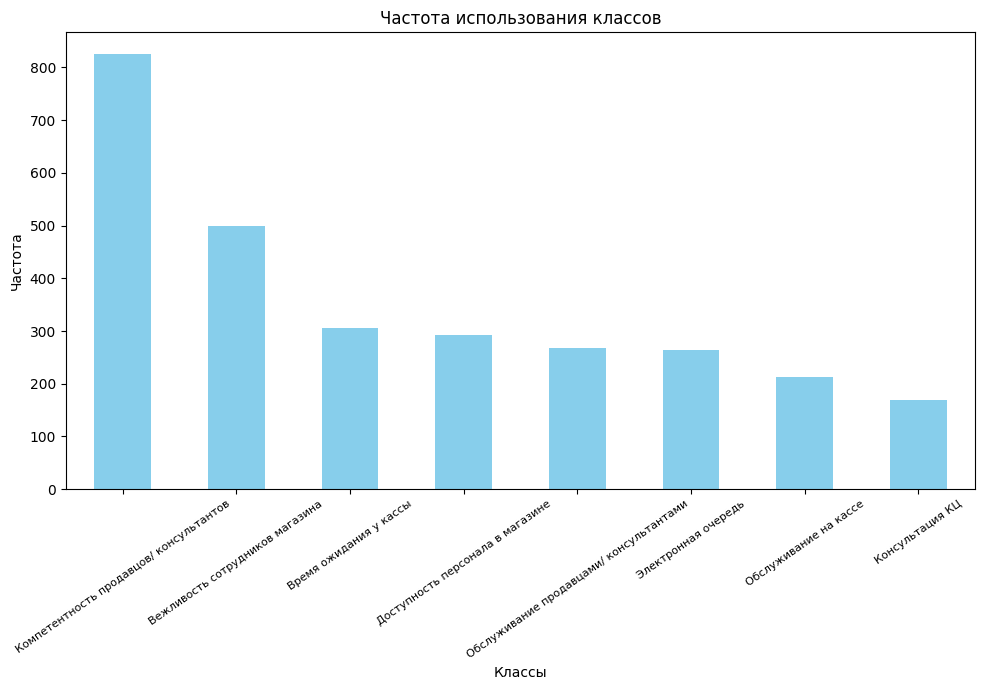

In [ ]:
# Подсчет количества уникальных значений в столбце 'class'
class_counts = df['class'].value_counts()

# Создание графика
plt.figure(figsize=(10, 7))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Частота использования классов')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(fontsize=8)
plt.xticks(rotation = 35)
plt.tight_layout()
plt.show()

In [ ]:
print(class_counts)

Компетентность продавцов/ консультантов    825
Вежливость сотрудников магазина            500
Время ожидания у кассы                     306
Доступность персонала в магазине           293
Обслуживание продавцами/ консультантами    267
Электронная очередь                        264
Обслуживание на кассе                      212
Консультация КЦ                            170
Name: class, dtype: int64


*Проверим, все ли отзывы клиентов написаны на русском языке*

In [ ]:
nltk.download('words')

english_words = set(words.words())

def has_english_words(text):
    words_in_text = text.split()
    for word in words_in_text:
        if word.lower() in english_words:
            return True
    return False

df['has_english'] = df['text'].apply(has_english_words)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
if df['has_english'].any():
    print("Есть хотя бы одно значение True в колонке")
else:
    print("Нет значений True в колонке")

Есть хотя бы одно значение True в колонке


In [ ]:
filtered_texts = df[df['has_english'] == True]['text']
print(filtered_texts)

184     сотрудник дал не верную информацию по apple tv...
627     очень сожалею что обратился к вам 25.12.2022 п...
670     добрый день. хотел купить в рассрочку планшет ...
685     расна терминале талон по выдаче интернет заказ...
940     консультант ввел в заблуждение и продал неподх...
1027    мне не понравилось , что на кассе меня запутал...
1040    отвратительная работа. товар не соответствует ...
1083    отвратительная работа сотрудников call center....
1084    просьба вернуть мне деньги за наушники, т к оп...
1486    сотрудники выдавшие заказ, были мягко сказать ...
1728    товар хороший. покупал раньше. повторил заказ....
2127    добрый день.  дважды общался с операторами кол...
2155    ужасное качество обслуживания. сотрудники инте...
2445    пришел в 10 утра забирать заказ, с кассовой зо...
2541    как обычно: эл очередь живет отдельно от выдач...
Name: text, dtype: object


*Так как среди комментариев есть иностранные символы - очистим набор данных от них, специальных символов и заглавных букв*

*Очистим датафрейм от специальных символов, заглавных букв и разделителей строк*



In [ ]:
def cleaning(text):
    # Удаляем переводы строк
    text = re.sub(r"(?:\n|\r)", " ", text)
    # Удаляем спецсимволы и цифры, оставляем только русские и английские буквы
    text = re.sub(r"[^a-zA-Zа-яА-Я\s]", '', text)
    # Приводим к нижнему регистру
    text = text.lower()
    return text

df['text'] = df['text'].apply(cleaning)
df_backup['text'] = df_backup['text'].apply(cleaning)
print(df.head(20))

    Unnamed: 0   id                                               text  \
0            0   45   негатив к вам и горячей линии которые нафиг н...   
1            1   97  перестаньте впаривать клиентам дополнительные ...   
2            2  105   продавец предложил наклеить защитную плнку за...   
3            3  127  продавец режил продать нам товар почему то по ...   
4            4  130  навязанные услуги  без моего согласия на сумму...   
5            5  168  оператор проигнорировала информацию об ошибке ...   
6            6  181  сотрудник мало того что задал вопросы по повод...   
7            7  206  электронные талоны в приложении не работают пр...   
8            8  221        приложение не работало чтобы получить талон   
9            9  224  хотели оформить заказ через приложениено сотру...   
10          10  230  продавцами  нет отдали товар и не предложили в...   
11          11  241       консультантов в зале надо искать с собаками    
12          12  250   приехала продавц

*Добавим кодировку классов как дополнительный признак*

In [ ]:
df['class_id'] = df['class'].factorize()[0]
df['class_id'].value_counts()


df_backup['class_id'] = df_backup['class'].factorize()[0]

In [ ]:
class_id_data = df[['class', 'class_id']].drop_duplicates().sort_values('class_id')
class_id_data_backup = df_backup[['class','class_id']].drop_duplicates().sort_values('class_id')
# Словарь для сверки id классов
class_to_id = dict(class_id_data.values)
id_to_class = dict(class_id_data[['class_id', 'class']].values)

id_to_class

{0: 'Консультация КЦ',
 1: 'Компетентность продавцов/ консультантов',
 2: 'Электронная очередь',
 3: 'Доступность персонала в магазине',
 4: 'Вежливость сотрудников магазина',
 5: 'Обслуживание на кассе',
 6: 'Обслуживание продавцами/ консультантами',
 7: 'Время ожидания у кассы'}

*Приступим к лемматизации текста*

In [ ]:
mystem = Mystem()

def lemmatize_text(text):
    # Лемматизация текста с помощью Mystem
    lemmas = mystem.lemmatize(text)
    # Объединение лемм в строку и удаление лишних символов
    processed_text = ''.join(lemmas).replace(' \n', '').strip()
    return processed_text

# Применение лемматизации к столбцу 'text'
df['lemmatized_text'] = df['text'].apply(lemmatize_text)
print(df)

      Unnamed: 0     id                                               text  \
0              0     45   негатив к вам и горячей линии которые нафиг н...   
1              1     97  перестаньте впаривать клиентам дополнительные ...   
2              2    105   продавец предложил наклеить защитную плнку за...   
3              3    127  продавец режил продать нам товар почему то по ...   
4              4    130  навязанные услуги  без моего согласия на сумму...   
...          ...    ...                                                ...   
2832        2832  17570  почему отключили электронную очередь через пол...   
2833        2833  17579  очередь на кассе продавцы не торопятся с заказ...   
2834        2834  17586  профессионализма менеджеру бы да и внимания к ...   
2835        2835  17591  сотрудник на выдаче заказа потребовал документ...   
2836        2836  17594                           клиентоориентированность   

                                        class  has_english  cla

*Посмотрим на среднюю длину комментариев в символах в столбце лемматизированного текста*

In [ ]:
average_length = df['lemmatized_text'].apply(lambda x: len(x)).mean()
print("Длина символов в столбце lemmatized_text:", average_length)

Средняя длина символов в столбце lemmatized_text: 200.00105745505817


*Добавим переменные для удобства*

In [ ]:
sentences = df_backup['text']
labels = df_backup['class_id']
print(sentences[22], labels[22])

продавец подсунул в чек какуюто электронную подписку за  рублей 1


*Удалим ненужные колонки*

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'text', 'class', 'has_english', 'class_id',
       'lemmatized_text'],
      dtype='object')

In [ ]:
df = df.drop(['id', 'Unnamed: 0','text','has_english'], axis=1)

df.columns

Index(['class', 'class_id', 'lemmatized_text'], dtype='object')

In [ ]:
target = df['class']
features = df.drop(['class'], axis=1)
stopwords = stopwords.words('english')

features_train, features_test, target_train, target_test=train_test_split(df, target,test_size=0.1,random_state=42)

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train_idf = count_tf_idf.fit_transform(features_train['lemmatized_text'])
features_test_idf = count_tf_idf.transform(features_test['lemmatized_text'])

print(features_train.shape)
print(features_test.shape)

(2553, 3)
(284, 3)


In [ ]:
label_encoder = LabelEncoder()

# Преобразование текстовых меток классов в числовые значения
target_train_encoded = label_encoder.fit_transform(target_train)
target_test_encoded = label_encoder.transform(target_test)

**Итог первого этапа**

На данном этапе мы ознакомились с данными, узнали их тип, общее количество строк. Проверили на дубликаты, очистили данные от специальных символов, заглавных букв и разделителей строк, а затем провели лемматизацию текста. Выявили дисбаланс классов, ресемплировали данные и высчитали предварительную F1 меру с помощью кроссвалидации.

**Обучение**

*Взглянем на показатель DummyClassifier*

In [ ]:
#from sklearn.dummy import DummyClassifier
#dummy_grid = {
 #   'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant'],
 #   'constant': ['Вежливость сотрудников магазина', 'Время ожидания у кассы']
#}

#dummy = DummyClassifier(random_state=42)
#dummy_gs = GridSearchCV(dummy, param_grid=dummy_grid, cv=5)
#dummy_gs.fit(features_train, target_train)

#print(dummy_gs.best_score_)

In [ ]:
dummy_grid = {
    'strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant'],
    'constant': ['Вежливость сотрудников магазина', 'Время ожидания у кассы']
}

dummy_model = DummyClassifier(random_state=42)
best_dummy_model = dummy_mod(dummy_model, dummy_grid, features_train, target_train)

*Logistic Regression*

In [ ]:
%%time
# Создание пайплайна с моделью LogisticRegression
#pipe = Pipeline([
#    ('model', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
#])
# Создание параметров для GridSearchCV
#param_grid = [
#    {
#        'model__penalty': ['l1', 'l2'],
 #       'model__C': list(range(1, 15, 3))
#   }
#]

# Создание метрики f1_weighted с помощью make_scorer
#scorer = make_scorer(f1_score, average='weighted')

# Создание объекта GridSearchCV с указанием метрики scorer
#grid = GridSearchCV(pipe, param_grid=param_grid, scoring=scorer, cv=10, verbose=True, n_jobs=-1)

# Обучение модели
#best_grid = grid.fit(features_train_idf, target_train)

#print('Лучшие параметры:', grid.best_params_)
#print('Лучшая метрика (F1 weighted):', grid.best_score_)

In [ ]:
logreg_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
param_grid = {'model__penalty': ['l1', 'l2'], 'model__C': list(range(1, 15, 3))}

best_logreg_model, logreg_predictions = logreg_mod(logreg_model, param_grid, features_train_idf, target_train_encoded, features_test_idf)

In [ ]:
# Получение прогнозов на тестовой выборке
#predictions = best_grid.predict(features_test_idf)

# Вычисление F1-скора на тестовой выборке
#f1_test_score = f1_score(target_test, predictions, average='weighted')
#print('F1-скор на тестовой выборке:', f1_test_score)

In [ ]:
# Получение предсказаний на тестовых данных
#predicted = best_grid.predict(features_test_idf)

# Вычисление confusion matrix
#cm = confusion_matrix(target_test, predicted)
#print(cm)

*Random Forest*

In [ ]:
# Создание и обучение модели RandomForestClassifier
#rfc_model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
#rfc_model.fit(features_train_idf, target_train)

# Предсказание на тестовом наборе данных
#y_pred = rfc_model.predict(features_test_idf)

# Рассчет F1-меры
#f1 = f1_score(target_test, y_pred, average='weighted')
#print("F1-score:", f1)

In [ ]:
best_rf_model, rf_predictions = rf_model(features_train_idf, target_train, features_test_idf, target_test)


*KNN*

In [ ]:
# Определение функции для оценки модели и вывода F1-меры
#def calculate_f1_score(true, predicted):
 #   return f1_score(true, predicted, average='weighted')

# Функция для обучения модели и получения предсказаний
#def modeling(model, params, features_train_idf, target_train_encoded, features_test_idf):
  #  grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1_macro', cv=5)
  #  grid.fit(features_train_idf, target_train_encoded)
 #   print(f'Лучшие параметры: {grid.best_params_}')

  #  best_model = grid.best_estimator_
 #   best_model.fit(features_train_idf, target_train_encoded)
 #   predictions = best_model.predict(features_test_idf)
  #  return best_model, predictions


#KNN_model = KNeighborsClassifier()
#KNN_params = {'n_neighbors': np.arange(3, 50, 2)}

#best_KNN_model, KNN_y = modeling(KNN_model, KNN_params, features_train_idf, target_train_encoded, features_test_idf)
#f1 = calculate_f1_score(target_test_encoded, KNN_y)
#print(f'F1-мера: {f1}')

In [ ]:
KNN_model = KNeighborsClassifier()
KNN_params = {'n_neighbors': np.arange(3, 50, 2)}

best_KNN_model, KNN_y = modeling(KNN_model, KNN_params, features_train_idf, target_train_encoded, features_test_idf)
f1 = calculate_f1_score(target_test_encoded, KNN_y)
print(f'F1-мера: {f1}')


*Multinominal Naive Bayes*

In [ ]:
# Создание сетки параметров
#mnb_grid = {
#    'alpha': [0.1, 0.2, 0.5, 0.8, 1.0],
#    'fit_prior': [True, False],
#    'class_prior': [None]
#}

#mnb = MultinomialNB()

#mnb_tfidf_gs = GridSearchCV(mnb, param_grid=mnb_grid, cv=5)
#mnb_tfidf_gs.fit(features_train_idf, target_train)
#print(mnb_tfidf_gs.best_score_)

In [ ]:
# Создание сетки параметров
mnb_grid = {
    'alpha': [0.1, 0.2, 0.5, 0.8, 1.0],
    'fit_prior': [True, False],
    'class_prior': [None]
}

mnb = MultinomialNB()

# Использование функции для обучения модели
best_mnb_model, mnb_predictions = mnb_model(mnb, mnb_grid, features_train_idf, target_train, features_test_idf, target_test)

*SVM*

In [ ]:
features_train_sub, features_val, target_train_sub, target_val = train_test_split(features_train_idf, target_train, random_state = 42, test_size=0.10)

In [ ]:
def objective(trial):
    from sklearn.svm import SVC
    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e4),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'kernel': trial.suggest_categorical("kernel", ["linear", "rbf"])
    }

    svc = SVC(**params)
    svc.fit(features_train_sub, target_train_sub)
    return svc.score(features_val, target_val)

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                            direction="maximize",
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-12-17 19:16:31,127] A new study created in memory with name: no-name-de0afdf2-4105-45a7-b598-63408f215c2a


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:32,072] Trial 0 finished with value: 0.8125 and parameters: {'C': 37.30383528143735, 'gamma': 0.01945873840348015, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:32,865] Trial 1 finished with value: 0.828125 and parameters: {'C': 56.98384608345693, 'gamma': 0.24257815076676031, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:33,896] Trial 2 finished with value: 0.59765625 and parameters: {'C': 0.7038096413827089, 'gamma': 0.13706928443177713, 'kernel': 'rbf'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:35,413] Trial 3 finished with value: 0.25 and parameters: {'C': 0.32253582308744194, 'gamma': 0.0003002086301848454, 'kernel': 'rbf'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:36,104] Trial 4 finished with value: 0.25 and parameters: {'C': 0.0028835922101179585, 'gamma': 0.0025328767014880767, 'kernel': 'rbf'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:37,024] Trial 5 finished with value: 0.828125 and parameters: {'C': 11.890706744202372, 'gamma': 624.3877193292781, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:37,642] Trial 6 finished with value: 0.828125 and parameters: {'C': 60.19314852321079, 'gamma': 0.03834169523641596, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:38,250] Trial 7 finished with value: 0.25 and parameters: {'C': 0.0223723894683578, 'gamma': 11.163721427400015, 'kernel': 'rbf'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:38,712] Trial 8 finished with value: 0.67578125 and parameters: {'C': 0.27983504785193886, 'gamma': 0.8901860438096811, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:39,225] Trial 9 finished with value: 0.66015625 and parameters: {'C': 0.25751969879039616, 'gamma': 1403.1797383500177, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:39,703] Trial 10 finished with value: 0.828125 and parameters: {'C': 7496.147874229745, 'gamma': 30.23061853671138, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:40,180] Trial 11 finished with value: 0.828125 and parameters: {'C': 89.43501730677391, 'gamma': 8032.817764730678, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:40,686] Trial 12 finished with value: 0.828125 and parameters: {'C': 2084.7339754759873, 'gamma': 86.94556002712592, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:40,976] Trial 13 finished with value: 0.828125 and parameters: {'C': 12.80621951427453, 'gamma': 4.354491272223255, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:41,498] Trial 14 finished with value: 0.828125 and parameters: {'C': 909.3477558609468, 'gamma': 377.1344364033317, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:42,032] Trial 15 finished with value: 0.828125 and parameters: {'C': 13.075393455924235, 'gamma': 0.5473361356086304, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:42,628] Trial 16 finished with value: 0.828125 and parameters: {'C': 256.95121007694956, 'gamma': 9325.72633835406, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:43,240] Trial 17 finished with value: 0.25 and parameters: {'C': 0.00010766468109931833, 'gamma': 0.0036708911461566965, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:43,684] Trial 18 finished with value: 0.82421875 and parameters: {'C': 3.173946982582924, 'gamma': 146.00194352553152, 'kernel': 'linear'}. Best is trial 1 with value: 0.828125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:44,128] Trial 19 finished with value: 0.83203125 and parameters: {'C': 4.378712388921824, 'gamma': 3.239606544876332, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:44,507] Trial 20 finished with value: 0.25 and parameters: {'C': 0.014595134262841751, 'gamma': 4.372379960154772, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:44,937] Trial 21 finished with value: 0.82421875 and parameters: {'C': 3.0004871777664848, 'gamma': 0.28553434864652166, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:45,507] Trial 22 finished with value: 0.83203125 and parameters: {'C': 4.358701060230022, 'gamma': 934.4814377051886, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:46,024] Trial 23 finished with value: 0.828125 and parameters: {'C': 333.44999707664283, 'gamma': 2.810765720541182, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:46,665] Trial 24 finished with value: 0.8125 and parameters: {'C': 2.1549662858028817, 'gamma': 0.06040862098436505, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:47,159] Trial 25 finished with value: 0.25390625 and parameters: {'C': 0.023159830513059785, 'gamma': 46.527854571221496, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:47,875] Trial 26 finished with value: 0.25 and parameters: {'C': 0.06444059927966475, 'gamma': 0.011301224815017974, 'kernel': 'rbf'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:48,581] Trial 27 finished with value: 0.83203125 and parameters: {'C': 6.124245219355528, 'gamma': 17.011277459214487, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:48,958] Trial 28 finished with value: 0.83203125 and parameters: {'C': 5.694542290588618, 'gamma': 14.797278949682301, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:49,495] Trial 29 finished with value: 0.2578125 and parameters: {'C': 1.400184022058099, 'gamma': 2238.421769276098, 'kernel': 'rbf'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:49,882] Trial 30 finished with value: 0.828125 and parameters: {'C': 27.795490319674926, 'gamma': 221.95742515963983, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:50,267] Trial 31 finished with value: 0.83203125 and parameters: {'C': 5.33614864912539, 'gamma': 21.051877306582686, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:50,525] Trial 32 finished with value: 0.796875 and parameters: {'C': 0.8572733759470422, 'gamma': 2.0723952518533215, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:50,810] Trial 33 finished with value: 0.828125 and parameters: {'C': 161.19612660031626, 'gamma': 14.916099792774485, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:51,086] Trial 34 finished with value: 0.828125 and parameters: {'C': 18.542587151323797, 'gamma': 7.9971325445492845, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:51,501] Trial 35 finished with value: 0.2578125 and parameters: {'C': 6.31193767616531, 'gamma': 48.75979164849661, 'kernel': 'rbf'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:51,755] Trial 36 finished with value: 0.7421875 and parameters: {'C': 0.42340176030592036, 'gamma': 1119.7574802842394, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:52,041] Trial 37 finished with value: 0.2734375 and parameters: {'C': 0.13222401815685425, 'gamma': 1.472726383319021, 'kernel': 'rbf'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:52,320] Trial 38 finished with value: 0.828125 and parameters: {'C': 58.56036147142568, 'gamma': 104.03013936954113, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:52,583] Trial 39 finished with value: 0.796875 and parameters: {'C': 0.9382145153688068, 'gamma': 0.00012726213888249868, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:52,884] Trial 40 finished with value: 0.80078125 and parameters: {'C': 5.155845756375528, 'gamma': 0.34819910198749243, 'kernel': 'rbf'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:53,154] Trial 41 finished with value: 0.83203125 and parameters: {'C': 6.947313965369547, 'gamma': 19.044912254872003, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:53,427] Trial 42 finished with value: 0.82421875 and parameters: {'C': 3.225165461999786, 'gamma': 8.05950212504647, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:53,721] Trial 43 finished with value: 0.828125 and parameters: {'C': 33.89112599037282, 'gamma': 0.1173549214221024, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:53,995] Trial 44 finished with value: 0.765625 and parameters: {'C': 0.5076647413894055, 'gamma': 434.7972231641108, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:54,290] Trial 45 finished with value: 0.828125 and parameters: {'C': 9.70065874331261, 'gamma': 26.986514621146178, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:54,528] Trial 46 finished with value: 0.5859375 and parameters: {'C': 0.1386296302534107, 'gamma': 0.9019491162152944, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:54,811] Trial 47 finished with value: 0.828125 and parameters: {'C': 99.9757379750985, 'gamma': 3958.538923921463, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:55,089] Trial 48 finished with value: 0.8125 and parameters: {'C': 1.4977568148692992, 'gamma': 64.41391398839285, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


<ipython-input-48-b65d2512e882>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e4),
<ipython-input-48-b65d2512e882>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),


[I 2023-12-17 19:16:55,367] Trial 49 finished with value: 0.828125 and parameters: {'C': 22.433557687948234, 'gamma': 214.5755247941962, 'kernel': 'linear'}. Best is trial 19 with value: 0.83203125.


In [ ]:
print(f"Лучшее значение: {study.best_trial.value}")
print(f"Лучшие параметры: {study.best_params}")

Лучшее значение: 0.83203125
Лучшие параметры: {'C': 4.378712388921824, 'gamma': 3.239606544876332, 'kernel': 'linear'}


***Сравнение моделей***

                      Model  Score
0                       SVM  0.832
1       Logistic Regression  0.774
2  Multinominal Naive Bayes  0.698
3                       KNN  0.675
4           DummyClassifier  0.286
5             Random Forest  0.168


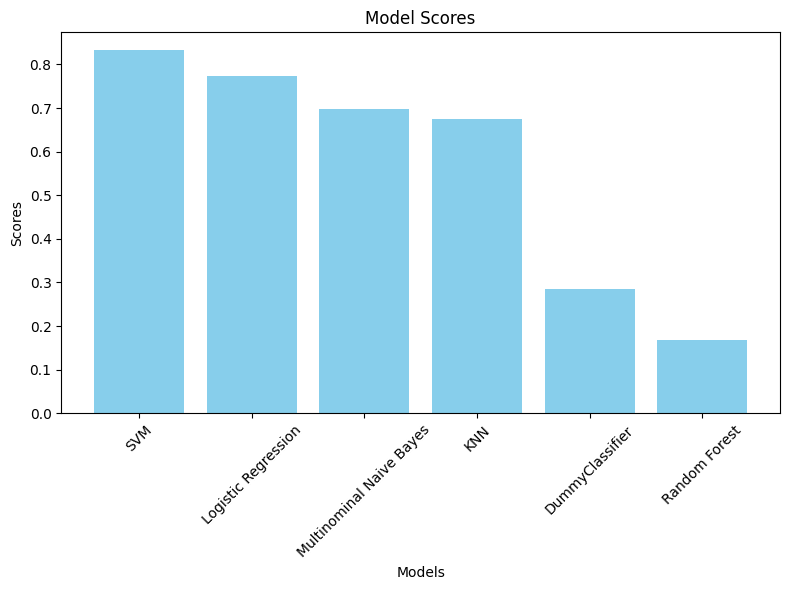

In [ ]:
# Ваши вручную введенные данные
model_scores = {
    'SVM': 0.832,
    'Logistic Regression': 0.774,
    'Multinominal Naive Bayes': 0.698,
    'KNN': 0.675,
    'DummyClassifier': 0.286,
    'Random Forest': 0.168
}

# Создание таблицы из словаря
df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Score'])

# Вывод таблицы
print(df)

# Построение гистограммы
plt.figure(figsize=(8, 6))
plt.bar(df['Model'], df['Score'], color='skyblue')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Вывод**

В ходе данного исследования была проведена обработка текста, создание новых столбцов-признаков, построены различные модели многоклассовой классификации для отзывов клиентов с учетом балансировки классов. Лучшими оказались: SVM и Logistic Regression с score = 0.832 и 0.784 соответственно при показателе baseline от Dummy Classifier = 0.286. Модели показывают себя наилучшим образом при обработке текста с помощью TF-IDF и использованием GridSearch. Также, использование Optuna сильно ускоряет процесс обучения и получения результатов. Однако, наиболее подходящими к этой задаче можно считать модели BERT и использование CNN, добавлю решения с их использованием позже.